# **Simplifying CNN - Generative Adversarial Network**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**
* **Note: GANs need to be complex to capture even the simplest details**

In [1]:
# important libraries

# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

import sys

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device=tr.device('cuda' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
nImages=3000
imgSize=64

x=np.linspace(-4,4,imgSize)
X,Y=np.meshgrid(x,x)

# initialize tensors containing images and labels
images=tr.zeros(nImages,1,imgSize,imgSize)

for i in range(nImages):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro --> random offset
    width=np.random.rand()/0.6 + 1.8 # random width
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*width**2))

    # and add noise 
    G=G+np.random.randn(imgSize,imgSize)/5

    # add to the tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)

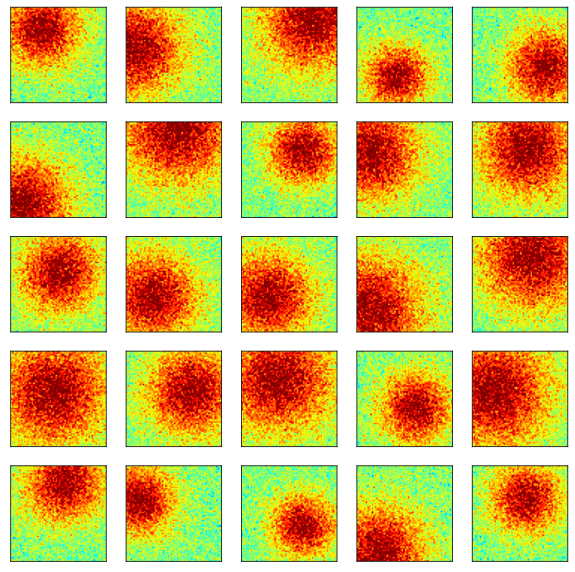

In [4]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(3000)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

**Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html**

In [5]:
# Create the discriminator and generator

class DiscriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(1,64,4,3,0,bias=False)
        self.conv2 = nn.Conv2d(64,128,4,3,0,bias=False)
        self.conv3 = nn.Conv2d(128,1,4,3,0,bias=False)

        # batchnormalization
        self.bn2 = nn.BatchNorm2d(128)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=self.bn2(x)
        return tr.sigmoid(self.conv3(x)).view(-1,1)

dnet=DiscriminatorNet()
y=dnet(tr.randn(10,1,64,64))
y

tensor([[0.6964],
        [0.4876],
        [0.2968],
        [0.6052],
        [0.5242],
        [0.3448],
        [0.3916],
        [0.5561],
        [0.6742],
        [0.4353]], grad_fn=<ViewBackward0>)

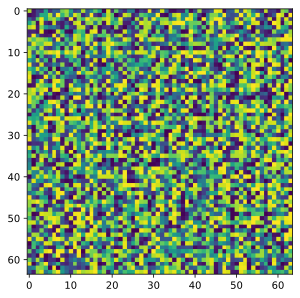

In [6]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv1=nn.ConvTranspose2d(100,256,4,4,0,bias=False)
        self.conv2=nn.ConvTranspose2d(256,128,4,4,0,bias=False)
        self.conv3=nn.ConvTranspose2d(128,1,4,4,0,bias=False)

        # batchnorm
        self.bn2=nn.BatchNorm2d(256)
        self.bn3=nn.BatchNorm2d(128)


    
    def forward(self,x):
        x=F.relu(self.bn2(self.conv1(x)))
        x=F.relu(self.bn3(self.conv2(x)))
        return tr.tanh(self.conv3(x))
    
gnet=GeneratorNet()
y=gnet(tr.randn(10,100,1,1))
plt.imshow(y[0,:,:,:].squeeze().detach().numpy())
plt.show()

In [26]:
# train the models
lossfun=nn.BCELoss()

dnet=DiscriminatorNet().to(device)
gnet=GeneratorNet().to(device)

d_optimizer=tr.optim.Adam(dnet.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer=tr.optim.Adam(gnet.parameters(),lr=0.0002,betas=(0.5,0.999))

In [ ]:
# training params and initializations
numepochs=1500
batchsize=86
losses=[]
disDecs=[]

for epochi in range(numepochs):
    # create a mini batch from randomly selected images
    ridx=tr.randint(images.shape[0],(batchsize,))
    data=images[ridx,:].to(device)

    # create labels for real and fake images
    real_labels=tr.ones(batchsize,1).to(device)
    fake_labels=tr.zeros(batchsize,1).to(device)

    ### train the discriminator

    # forward pass and loss for real pictures
    pred_real=dnet(data)    # output of discriminator
    d_loss_real=lossfun(pred_real,real_labels)   # all labels are 1

    # forward pass and loss for fake pictures
    fake_data=tr.randn(batchsize,100,1,1).to(device)
    fake_images=gnet(fake_data)                  
    pred_fake=dnet(fake_images)                  # output of generator
    d_loss_fake=lossfun(pred_fake,fake_labels)  # all labels are 0

    # collect loss (using combined losses)
    d_loss=d_loss_fake+d_loss_real

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### train the generator

    # create fake images and compute loss
    fake_data=tr.randn(batchsize,100,1,1).to(device)
    fake_images=gnet(fake_data)   
    pred_fake=dnet(fake_images)      

    # compute loss
    g_loss=lossfun(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])

    d1=tr.mean((pred_real>0.5).float()).detach()
    d2=tr.mean((pred_fake>0.5).float()).detach()
    disDecs.append([d1,d2])

    # print out a status message
    if (epochi+1)%50==0:
        msg=f'Finished epoch {epochi + 1}/{numepochs}'
        sys.stdout.write('\r'+msg)

# convert the performance from list to numpy array
losses=np.array(losses)
disDecs=np.array(disDecs)

In [ ]:
# create a 1D smoothing filter  
def smooth(x,k=15):
    return np.convolve(x,np.ones(k)/k,mode='same')

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title("Model Loss")
ax[0].legend(['Discriminator','Generator'])

ax[1].plot(losses[:,0],losses[:,1],'k.',alpha=0.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel("Generator loss")

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

In [ ]:
# generated gaussians
gnet.eval()
fake_data=gnet(tr.randn(batchsize,100,1,1).to(device)).cpu()

# and visualize
fig,axs=plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
    ax.axis('off')

plt.show()

**Additional Explorations**

In [27]:
# 1) Train the model for 200 epochs. Do the generated Gaussians still look like Gaussians?

# 2) The images are set to 64x64. Does the model still work if you make the images larger, e.g., 91x91? How about if they are smaller, e.g., 28x28 (the size of MNIST)?